<h1 align="center">Volume 4: Inverted Pendulum Problems.</h1>

    NAME Daniel Smith
    Section #2
    DATE 23 March 2022

In [1]:
import numpy as np
from scipy import optimize
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from scipy import linalg

# Problem 1

Write a function that returns the matrices A, B, Q, and R given above. Let
g = 9.8 m/s
2
.

In [3]:
def linearized_init(M, m, l, q1, q2, q3, q4, r):
    '''
    Parameters:
    ----------
    M, m: floats
          masses of the rickshaw and the present
    l   : float
          length of the rod
    q1, q2, q3, q4, r : floats
        relative weights of the position and velocity of the rickshaw, the
        angular displacement theta and the change in theta, and the control


    Return
    -------
    A : ndarray of shape (4,4)
    B : ndarray of shape (4,1)
    Q : ndarray of shape (4,4)
    R : ndarray of shape (1,1)
    '''
    g = 9.8 # Initialize g and define A, B, Q, and R
    A = np.array([[0, 1, 0, 0], [0, 0, (m*g)/M, 0], [0, 0, 0, 1], [0, 0, (g/(M*l))*(M + m), 0]])
    B = np.array([0, 1/M, 0, 1/(M*l)])
    Q = np.diag([q1, q2, q3, q4])
    R = np.array([r])
    return A, B, Q, R

# Problem 2

Write the following function to find the matrix P. Use scipy.optimize.root.
Since root takes in a vector and not a matrix, you will have to reshape the matrix P before
passing it in and after getting your result, using np.reshape(16) and np.reshape((4,4)).

In [29]:
def find_P(A,B,Q,R):
    '''
    Parameters:
    ----------
    A, B, Q : ndarrays of shape (4,4)
    R : ndarray of shape (1,1)
    
    Returns
    -------
    P : the matrix solution of the Riccati equation
    '''
    AT = A.T
    AT = A.reshape(16) # Reshape AT, A, and Q
    A = A.reshape(16) 
    Q = Q.reshape(16)
    temp = np.outer(B, B)/R # Calculate B@B.T/R
    temp = temp.reshape(16) # Reshape B@B.T/R
    
    def func(P): # Root function for solving for P
        return P*A + AT*P + Q - P*temp*P
    
    sol = optimize.root(func, np.zeros(16)) # Get the optimal P
    
    return sol.x.reshape((4, 4))

In [23]:
M, m = 23., 5. # Initialize values 
l = 4.
q1, q2, q3, q4 = 1., 1., 1., 1.
r = 10.

A, B, Q, R = linearized_init(M, m, l, q1, q2, q3, q4, r) # Get A, B, Q, and R

P = find_P(A, B, Q, R) # Get P

gov = A - (np.outer(B, B)/R)@P

w, v = np.linalg.eig(gov) # Check eigenvalues 
print(w)

[ 0.          0.01123086  1.72994372 -1.72414501]


## Problem 3
 
Write the following function that implements the LQR solution described earlier.
For the IVP solver, you can use your own or you may use the function odeint from scipy.
integrate.

In [24]:
def rickshaw(tv, X0, A, B, Q, R, P):
    '''
    Parameters:
    ----------
    tv : ndarray of time values, with shape (n+1,)
    X0 : Initial conditions on state variables
    A, Q: ndarrays of shape (4,4)
    B : ndarray of shape (4,1)
    R : ndarray of shape (1,1)
    P : ndarray of shape (4,4)
    Returns
    -------
    Z : ndarray of shape (n+1,4), the state vector at each time
    U : ndarray of shape (n+1,), the control values
    '''
    def ode(z, t): # ODE function 
        return (A - (np.outer(B, B)/R)@P)@z
    
    Z = odeint(ode, X0, tv) # Solve for Z
    u = [-B.T@P@Z[i]/R for i in range(n)] # Calculate u
    
    return Z, u

# Problem 4

Test the function made in Problem (3). Find the matrix P using the scipy.optimize.root method with tf=6 as well as the solve_continuous_are
method with tf=60. Plot the solutions z˜ and u˜. Compare your results as shown in Figure
21.3.

In [25]:
M, m = 23., 5. # Initialize values 
l = 4.
q1, q2, q3, q4 = 1., 1., 1., 1.
r = 10.
tf = 6
X0 = np.array([-1, -1, .1, -.2])
n = 200

A, B, Q, R = linearized_init(M, m, l, q1, q2, q3, q4, r) # Get A, B, Q, and R

P = find_P(A, B, Q, R) # Get P useing scipy.optimize.root

tv = np.linspace(0, tf, n) # Initialize time steps 

Z, u = rickshaw(tv, X0, A, B, Q, R, P) # Get Z and u

In [27]:
tf = 60 # Initialize time steps 
tv = np.linspace(0, tf, n)

Bs = np.array([[val] for val in B]) # Restructure B
Ps = linalg.solve_continuous_are(A, Bs, Q, R) # Get P using solve_continuous_are

Zs, us = rickshaw(tv, X0, A, B, Q, R, Ps) # Get Z and u

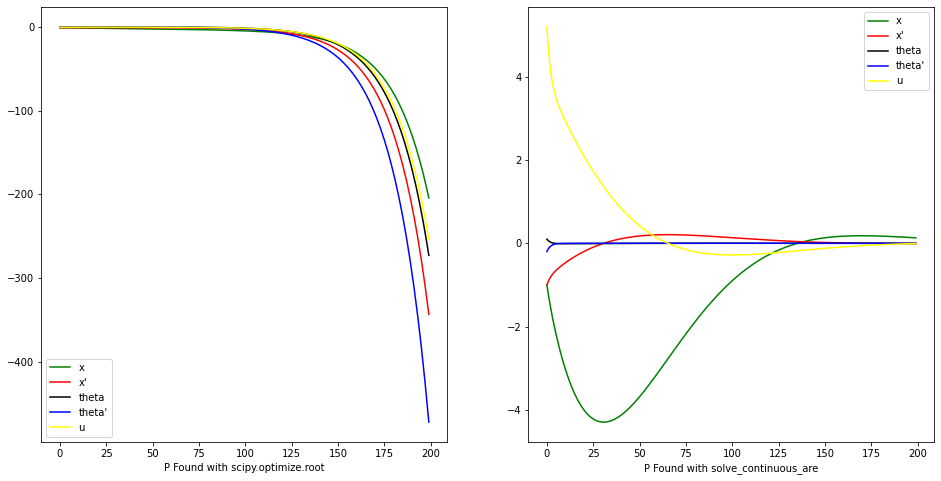

In [28]:
# Generate Plots for Problem 4
fig, ax = plt.subplots(1, 2, figsize = (16, 8))
ax[0].plot(Z[:, 0], label = "x", color = "green")
ax[0].plot(Z[:, 1], label = "x'", color = "red")
ax[0].plot(Z[:, 2], label = "theta", color = "black")
ax[0].plot(Z[:, 3], label = "theta'", color = "blue")
ax[0].plot(u, label = "u", color = "yellow")
ax[0].set_xlabel("P Found with scipy.optimize.root")
ax[0].legend()

ax[1].plot(Zs[:, 0], label = "x", color = "green")
ax[1].plot(Zs[:, 1], label = "x'", color = "red")
ax[1].plot(Zs[:, 2], label = "theta", color = "black")
ax[1].plot(Zs[:, 3], label = "theta'", color = "blue")
ax[1].plot(us, label = "u", color = "yellow")
ax[1].set_xlabel("P Found with solve_continuous_are")
ax[1].legend()
plt.show()